In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from clr_gat import CLRGAT
from dataloaders.dataloaders import UnlabelledDataset, get_episode_loader
from umap import UMAP
from sklearn.manifold import TSNE
import pytorch_lightning as pl
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
pl.seed_everything(72)

Global seed set to 72


72

In [3]:
sns.set_theme()

In [4]:
model = CLRGAT.load_from_checkpoint("7379345_72.1.ckpt").to("cuda")

MultiHeadDotProduct


/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/torch/nn/init.py:403: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


## Train Data

In [4]:
ds = UnlabelledDataset("miniimagenet", "/home/ojass/projects/unsupervised-meta-learning/data/untarred/", split="train", n_support=1, n_query=3, no_aug_support=True, img_size_orig=[84, 84])

In [5]:
from torch.utils.data import DataLoader

In [7]:
dl = DataLoader(ds, shuffle=True, num_workers=1, batch_size=64)

In [8]:
idl = iter(dl)

In [9]:
xs = next(idl)

In [10]:
s, q, l = xs["origs"], xs["views"], xs["labels"]

In [11]:
s_labels = l[:, 0]

In [12]:
x = torch.cat([s, q], dim=1)

In [13]:
import einops

In [14]:
x.shape

torch.Size([64, 4, 3, 84, 84])

In [15]:
x = einops.rearrange(x, 'b q c h w -> (b q) c h w')

In [16]:
model = model.to("cuda")

In [17]:
z_cnn, z = model.mpnn_forward(x.to("cuda"))

In [18]:
r = UMAP().fit_transform(z.cpu().detach().numpy())

In [19]:
import pandas as pd

In [20]:
c1, c2 = l.flatten().unique(return_counts=True)
df = pd.DataFrame({"label": c1, "count": c2})
df.head()

,label,count
0,1,4
1,2,8
2,5,16
3,6,12
4,7,4


In [21]:
df[df["count"] > 4]

,label,count
1,2,8
2,5,16
3,6,12
6,15,8
7,16,8
16,29,8
17,30,16
19,34,8
23,39,16
24,40,8


<AxesSubplot:>

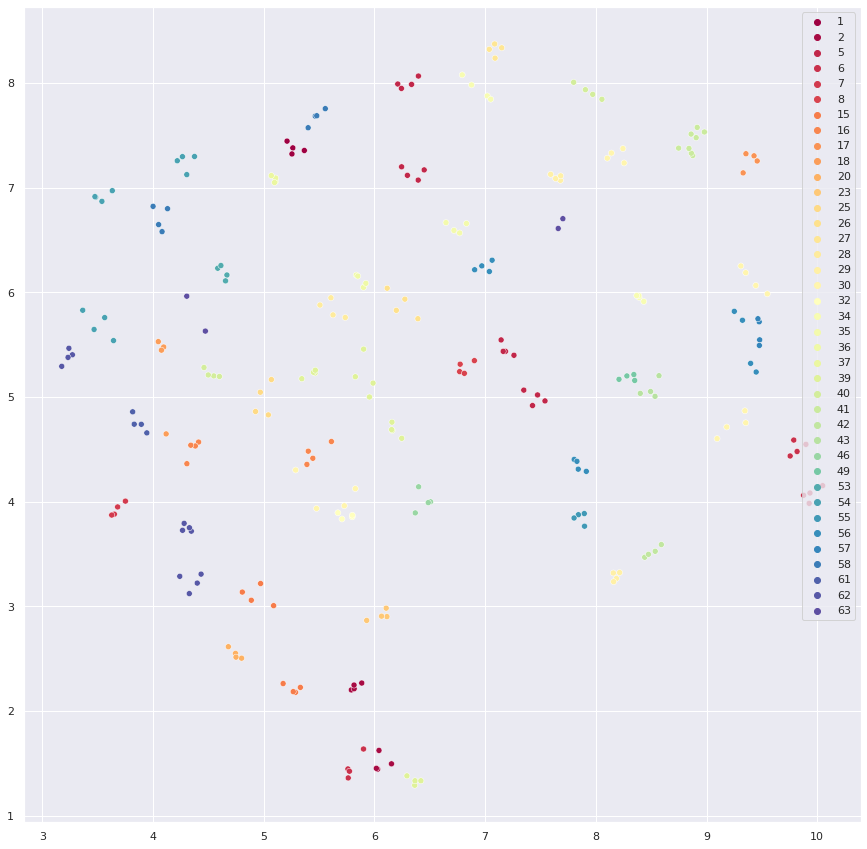

In [22]:
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(x=r[:, 0], y=r[:, 1], hue=l.flatten().cpu().numpy(), palette="Spectral", legend="full")

In [23]:
r = TSNE().fit_transform(z.cpu().detach().numpy())

/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/ojass/anaconda3/envs/ai/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


<AxesSubplot:>

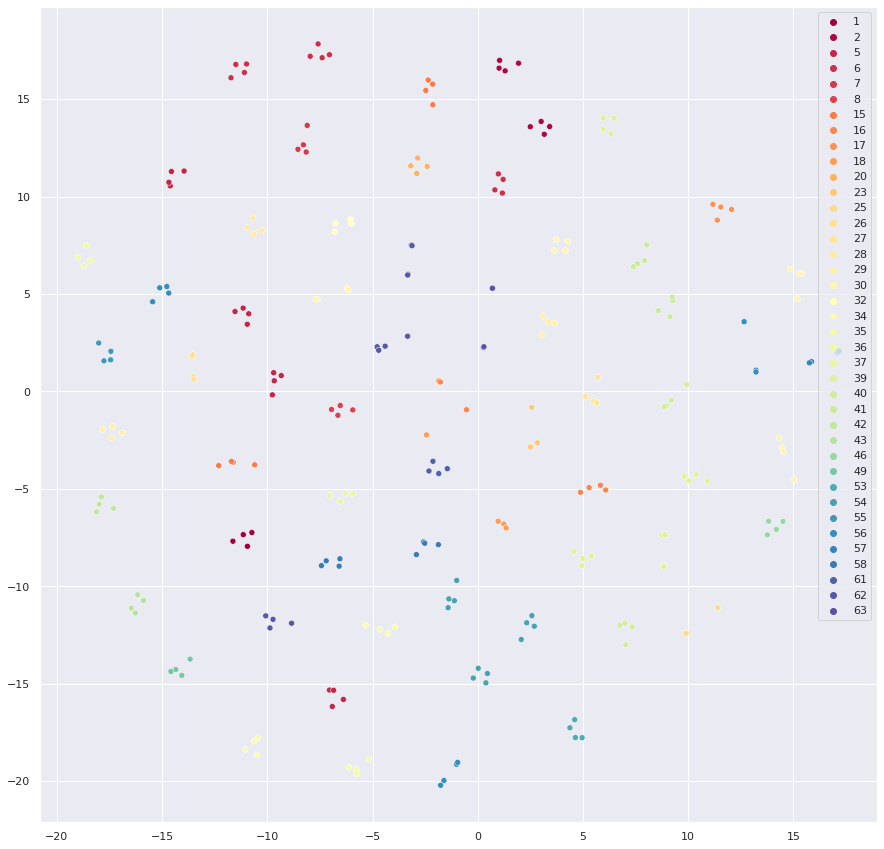

In [24]:
sns.set(rc={'figure.figsize':(15,15)})
sns.scatterplot(x=r[:, 0], y=r[:, 1], hue=l.flatten().cpu().numpy(), palette="Spectral", legend="full")

## Testing episdoic data

In [5]:
from optimal_transport.optimal_transport import OptimalTransport

In [202]:
k = 2
dl = get_episode_loader("miniimagenet", "/home/ojass/projects/unsupervised-meta-learning/data/untarred/", ways=k, shots=3, test_shots=15, batch_size=1, split="val")

Supervised data loader for miniimagenet:val.


In [203]:
idl = iter(dl)

In [229]:
for _ in range(10):
    xs = next(idl)

In [230]:
train = xs["train"]
test = xs["test"]

In [231]:
x_train = train[0][0]

In [232]:
y_train = train[1][0]

In [233]:
y_train

tensor([1, 1, 1, 0, 0, 0])

In [234]:
x_test = test[0][0]
y_test = test[1][0]

In [235]:
y_g = torch.ones_like(y_test) + 6

In [236]:
x = torch.cat([x_train, x_test])

In [237]:
torch.cuda.empty_cache()

In [238]:
z_o = model(x.to("cuda"))

In [239]:
y = torch.cat([y_train, y_g])

In [240]:
tru_y = torch.cat([y_train, y_test])

In [241]:
r_o = UMAP(n_neighbors=15).fit_transform(z_o.cpu().detach().numpy())

In [255]:
s = [150] * y_train.shape[-1] + [50] * y_test.shape[-1]

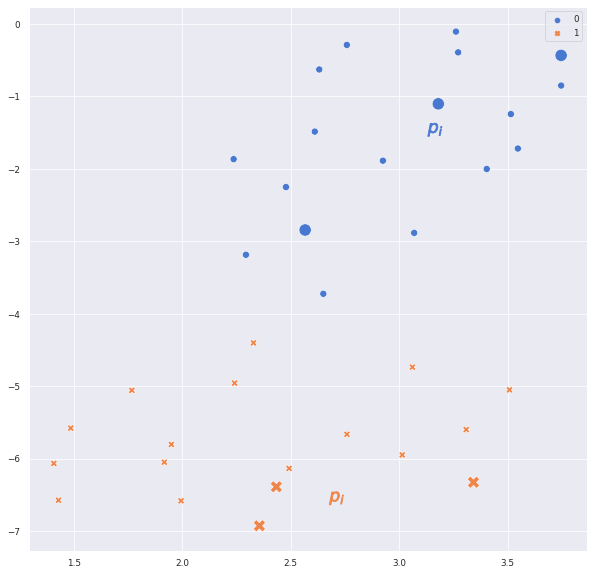

In [256]:
# sns.set(rc={'figure.figsize':(10,10)})
sns.set_context("paper")
fig, ax = plt.subplots(figsize=(10,10))
palette = sns.color_palette("muted", k)
plot1 = sns.scatterplot(x=r_o[:, 0], y=r_o[:, 1], hue=tru_y.cpu().numpy(), palette=palette, legend="auto", style=tru_y.cpu().numpy(), s=s, ax=ax)
protos1 = np.split(r_o, ([6, 30]))[0].reshape(k, -1, 2).mean(1)
# sns.scatterplot(x=protos1[:, 0], y=protos1[:, 1], hue=[1, 2, 0], palette=palette, legend="auto", markers=["h", "h", "h"], s=200)
plt.scatter(x=protos1[:, 0], y=protos1[:, 1], color=palette[::-1], s=200, marker='$p_i$')

In [257]:
fig1 = plot1.get_figure()

In [269]:
plot1.get_figure().savefig("raw_emb.pdf")

In [259]:
transportation_module = OptimalTransport(regularization=0.05, learn_regularization=False, max_iter=1000,
                                                     stopping_criterion=1e-4, device="cuda")

In [260]:
z_supp, z_query = z_o.split([6, 30])

In [261]:
z_supp, z_query = transportation_module(z_supp, z_query)

In [262]:
z = torch.cat([z_supp, z_query])

In [263]:
r = UMAP(n_neighbors=15).fit_transform(z.cpu().detach().numpy())

In [264]:
tru_y = torch.cat([y_train, y_test])
s = [150] * y_train.shape[-1] + [50] * y_test.shape[-1]

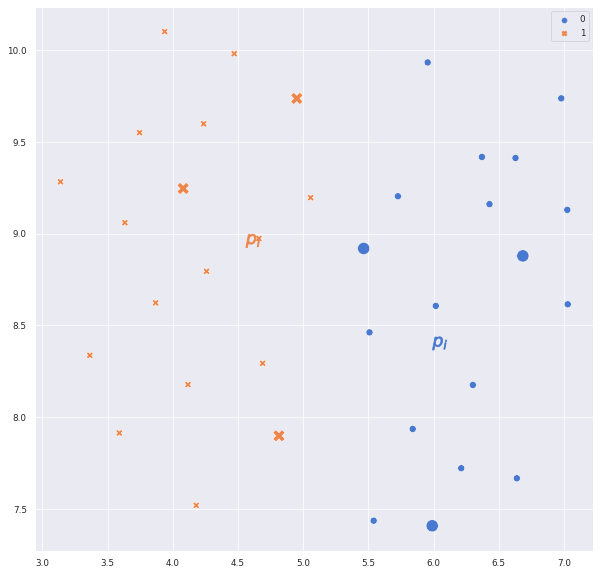

In [265]:
sns.set(rc={'figure.figsize':(10,10)})
sns.set_context("paper")
plot2 = sns.scatterplot(x=r[:, 0], y=r[:, 1], hue=tru_y.cpu().numpy(), palette=sns.color_palette("muted", k), legend="auto", style=tru_y.cpu().numpy(), s=s)
protos2 = np.split(r, ([6, 30]))[0].reshape(k, -1, 2).mean(1)
plt.scatter(x=protos2[:, 0], y=protos2[:, 1], c=sns.color_palette("muted", k)[::-1], s=200, marker='$p_i$')
# sns.scatterplot(x=protos2[:, 0], y=protos2[:, 1], hue=[1, 2, 0], palette=palette, legend="auto", markers=["h", "h", "h"], s=200)

In [268]:
plot2.get_figure().savefig("ot.pdf")

In [267]:
torch.save(x, "good_data1.dat")

# GradCAM stuff

In [270]:
# Hooks to capture the output and the gradients
class Hook_c():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o): self.stored = o.detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

class HookBwd():
    def __init__(self, m):
        self.hook = m.register_backward_hook(self.hook_func)   
    def hook_func(self, m, gi, go): self.stored = go[0].detach().clone()
    def __enter__(self, *args): return self
    def __exit__(self, *args): self.hook.remove()

In [271]:
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image, preprocess_image
from pytorch_grad_cam import GradCAM

In [328]:
class SimilarityToConcept:
    def __init__(self, features):
        self.features = features
    def __call__(self, model_output):
        print("here")
        cos = torch.nn.CosineSimilarity(dim=0)
        return cos(model_output, self.features)

In [372]:
target_layers = [model.model.backbone._feature_blocks[-2]]

In [493]:
from torchvision.utils import make_grid, save_image

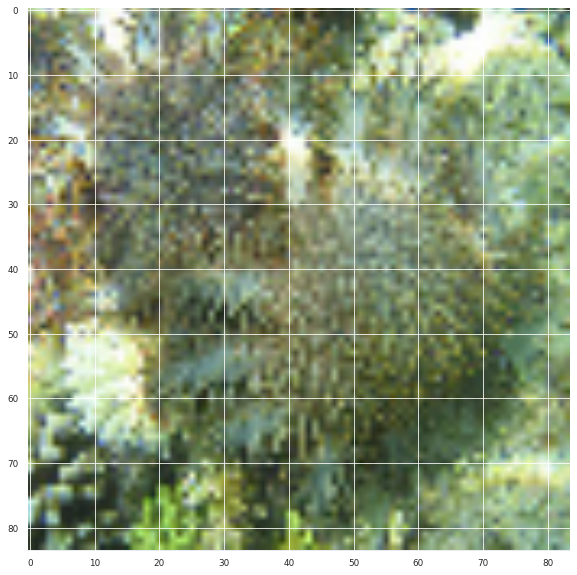

In [405]:
plt.imshow(x_train[3].permute(1, 2, 0), interpolation="bilinear")

In [504]:
transforms.ToPILImage()(x_train[3]).resize((224, 224)).save("green_thing_og.png")

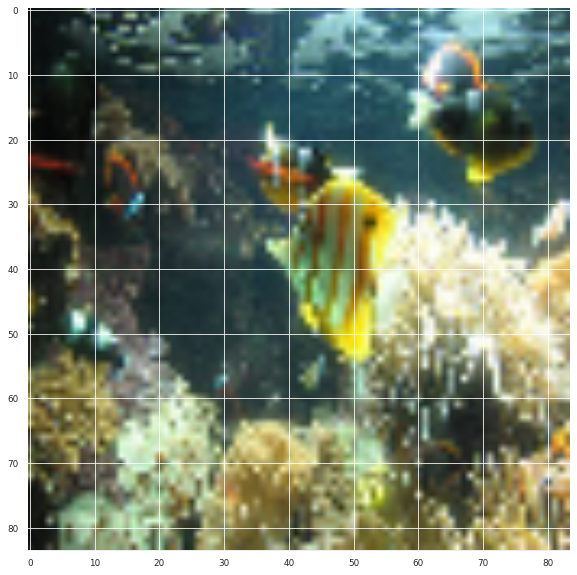

In [486]:
plt.imshow(x_test[16].permute(1, 2, 0), interpolation="bilinear")

In [317]:
x_train[3:].shape

torch.Size([3, 3, 84, 84])

In [339]:
ipod_concept_features, _ = model.mpnn_forward(x_train[0:3].to("cuda"))

In [342]:
ipod_concept_features = ipod_concept_features[0, :]

In [ ]:
transforms.ToPILImage()(x_train[])

In [343]:
some_green_water_stuff, _ = model.mpnn_forward(x_train[3:].to("cuda"))

In [344]:
some_green_water_stuff = some_green_water_stuff[0, :]

In [373]:
ipod_target = [SimilarityToConcept(ipod_concept_features)]
green_targets = [SimilarityToConcept(some_green_water_stuff)]

In [481]:
with GradCAM(model=model.model.backbone, target_layers=target_layers, use_cuda=True) as cam:
    cam_gray_scale = cam(input_tensor=x_test[14].unsqueeze(0), targets=ipod_target)[0, :]

here


In [482]:
cam_image = show_cam_on_image(x_test[14].permute(1, 2, 0).numpy(), cam_gray_scale, use_rgb=True)

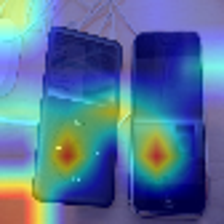

In [483]:
img1 = Image.fromarray(cam_image).resize([224, 224])
img1

In [484]:
img1.save("ipod1.png")

In [487]:
with GradCAM(model=model.model.backbone, target_layers=target_layers, use_cuda=True) as cam:
    cam_gray_scale = cam(input_tensor=x_test[16].unsqueeze(0), targets=green_targets)[0, :]

here


In [488]:
cam_image2 = show_cam_on_image(x_test[16].permute(1, 2, 0).numpy(), cam_gray_scale, use_rgb=True)

In [508]:
transforms.ToPILImage()(x_train[4]).resize((224, 224)).save("green_thing_og.png")

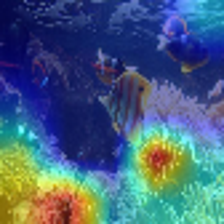

In [489]:
green_thing = Image.fromarray(cam_image2).resize((224, 224))
green_thing

In [495]:
green_thing.save("green_thing2.png")

In [496]:
save_image(x_test[16], "green_thing2_og.png")

In [499]:
from torchvision import transforms

In [503]:
transforms.ToPILImage()(x_test[16]).resize((224, 224)).save("green_thing2_og.png")